<a href="https://colab.research.google.com/github/EvgSkv/logica/blob/main/examples/Logica_example_Covid_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logica Example: Covid Analysis

In this CoLab we use Logica to extract two dataframes related to Covid pandemic from public BigQuery datasets.

1. To observe the spread of Covid over time we need timeseries for the countries in the top 10 by the absolte largest number of confirmed cases at the current moment. We want time series of active cases, confirmed cases, active cases per capita and confirmed cases per capita with granularity of 1 week.

2. To observe relationship between Covid and other factors we want a dataframe that for each country has the number of Covid confirmed cases and deaths as well as gdp, past life expectancy and overweight prevalence.

We are collecting this data from multiple tables 

## Install and import Logica

In [1]:
!pip install logica

     |████████████████████████████████| 573kB 7.6MB/s 


In [2]:
from logica import colab_logica
from google.colab import auth
auth.authenticate_user()
colab_logica.SetProject('YOUR_PROJECT_ID')

## Extracting time series

In [3]:
%%logica Series, CasesOverTime, TopCountries


#######################################################################
# Assigning short names to required BigQuery public data tables.

CovidData(..r) :- `bigquery-public-data.covid19_jhu_csse.summary`(..r);

Population(
    country:,
    population:) :-
  `bigquery-public-data.world_bank_global_population.population_by_country`(
      country: country_raw,
      year_2018: population
  ),
  country == (
      if country_raw == "United States" then
        "US"
      else if country_raw == "Iran, Islamic Rep." then
        "Iran"
      else if country_raw == "Russian Federation" then
        "Russia"
      else
        country_raw
  );

##########################
# Extracting the data.

# A function to retrieve population for a country.
# Returns null if the data is not there. We use it to avoid countries
# disappearing from the final table if the name didn't match.
PopulationOf(country) = population :-
  population AnyValue= (p :- Population(country:, population: p));

DayOfWeek(date) = SqlExpr("EXTRACT(DAYOFWEEK FROM {date})", {date:});

# Confirmed cases by country as of 4 days ago.
@OrderBy(CountryCases, "confirmed desc");
CountryCases(country: country_region,
             confirmed? += confirmed,
             population:) distinct :-
  CovidData(country_region:, confirmed:, date:),
  date == DateAddDay(CurrentDate(), -4),
  population == PopulationOf(country_region);

# Top 10 countries by the total number of confirmed cases.
@Limit(TopCountries, 10);
@OrderBy(TopCountries, "col1 desc");
TopCountries(country, confirmed) :-
  CountryCases(country:, confirmed:);

# Table with confirmed and active cases over time.
@OrderBy(CasesOverTime, "date");
CasesOverTime(
    country:,
    date: date_str,
    active_cases? += active,
    confirmed_cases? += confirmed,
    active_cases_per_capita? += active / PopulationOf(country),
    confirmed_cases_per_capita? += confirmed / PopulationOf(country)
    ) distinct :-
  CovidData(country_region: country, active:, confirmed:, date:),
  # Showing only Sundays to reduce number of points.
  DayOfWeek(date) == 1,
  date_str == FormatDate("%Y%m%d", date),
  TopCountries(country);

# Reframing the CasesOverTime table into a table with series for simpler
# plotting.
@OrderBy(Series, "series_name", "date");
Series(series_name:, country:, date:, value:) :-
  CasesOverTime(country:,
                date:,
                active_cases:,
                active_cases_per_capita:,
                confirmed_cases:,
                confirmed_cases_per_capita:),
  (
      (
        series_name == "Active Cases",
        value == active_cases           
      ) |
      (
          series_name == "Confirmed Cases",
          value == confirmed_cases
      ) |
      (
          series_name == "Active Cases Per Capita",
          value == active_cases_per_capita
      ) |
      (
          series_name == "Confirmed Cases Per Capita",
          value == confirmed_cases_per_capita
      )
  );



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running Series


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at Series_sql variable.
WITH t_5_CountryCases AS (SELECT
  t_8_bigquerypublicdata_covid19_jhu_csse_summary.country_region AS country,
  SUM(t_8_bigquerypublicdata_covid19_jhu_csse_summary.confirmed) AS confirmed,
  (SELECT
  ANY_VALUE(t_10_bigquerypublicdata_world_bank_global_population_population_by_country.year_2018) AS logica_value
FROM
  `bigquery-public-data.world_bank_global_population.population_by_country` AS t_10_bigquerypublicdata_world_bank_global_population_population_by_country
WHERE
  t_8_bigquerypublicdata_covid19_jhu_csse_summary.country_region = CASE WHEN t_10_bigquerypublicdata_world_bank_global_population_population_by_country.country = "United States" THEN "US" WHEN t_10_bigquerypublicdata_world_bank_global_population_population_by_country.country = "Iran, Islamic Rep." THEN "Iran" WHEN t_10_bigquerypublicdata_world_bank_global_population_population_by_country.country = "Russian Federation" THEN "Russia" ELSE t_10_bigquerypublicdata_wor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at Series variable.


,series_name,country,date,value
0,Active Cases,US,20200126,NaN
1,Active Cases,US,20200202,NaN
2,Active Cases,India,20200202,NaN
3,Active Cases,Spain,20200202,NaN
4,Active Cases,Russia,20200202,NaN
...,...,...,...,...
1327,Confirmed Cases Per Capita,Mexico,20201004,0.006036
1328,Confirmed Cases Per Capita,Russia,20201004,0.008368
1329,Confirmed Cases Per Capita,Colombia,20201004,0.017222
1330,Confirmed Cases Per Capita,Argentina,20201004,0.017946


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running CasesOverTime


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CasesOverTime_sql variable.
WITH t_4_CountryCases AS (SELECT
  t_7_bigquerypublicdata_covid19_jhu_csse_summary.country_region AS country,
  SUM(t_7_bigquerypublicdata_covid19_jhu_csse_summary.confirmed) AS confirmed,
  (SELECT
  ANY_VALUE(t_9_bigquerypublicdata_world_bank_global_population_population_by_country.year_2018) AS logica_value
FROM
  `bigquery-public-data.world_bank_global_population.population_by_country` AS t_9_bigquerypublicdata_world_bank_global_population_population_by_country
WHERE
  t_7_bigquerypublicdata_covid19_jhu_csse_summary.country_region = CASE WHEN t_9_bigquerypublicdata_world_bank_global_population_population_by_country.country = "United States" THEN "US" WHEN t_9_bigquerypublicdata_world_bank_global_population_population_by_country.country = "Iran, Islamic Rep." THEN "Iran" WHEN t_9_bigquerypublicdata_world_bank_global_population_population_by_country.country = "Russian Federation" THEN "Russia" ELSE t_9_bigquerypublicdata_wo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CasesOverTime variable.


,country,date,active_cases,confirmed_cases,active_cases_per_capita,confirmed_cases_per_capita
0,US,20200126,NaN,5,NaN,1.528269e-08
1,US,20200202,NaN,8,NaN,2.445231e-08
2,India,20200202,NaN,2,NaN,1.478615e-09
3,Spain,20200202,NaN,1,NaN,2.140239e-08
4,Russia,20200202,NaN,2,NaN,1.384293e-08
...,...,...,...,...,...,...
328,Mexico,20201004,37454.0,761665,0.000297,6.035821e-03
329,Russia,20201004,212291.0,1209039,0.001469,8.368323e-03
330,Colombia,20201004,66666.0,855052,0.001343,1.722205e-02
331,Argentina,20201004,140796.0,798486,0.003164,1.794572e-02


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running TopCountries


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at TopCountries_sql variable.
WITH t_0_CountryCases AS (SELECT
  bigquerypublicdata_covid19_jhu_csse_summary.country_region AS country,
  SUM(bigquerypublicdata_covid19_jhu_csse_summary.confirmed) AS confirmed,
  (SELECT
  ANY_VALUE(bigquerypublicdata_world_bank_global_population_population_by_country.year_2018) AS logica_value
FROM
  `bigquery-public-data.world_bank_global_population.population_by_country` AS bigquerypublicdata_world_bank_global_population_population_by_country
WHERE
  bigquerypublicdata_covid19_jhu_csse_summary.country_region = CASE WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "United States" THEN "US" WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "Iran, Islamic Rep." THEN "Iran" WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "Russian Federation" THEN "Russia" ELSE bigquerypublicdata_world_bank_global_population_population

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at TopCountries variable.


,col0,col1
0,US,7499341
1,India,6757131
2,Brazil,4969141
3,Russia,1231277
4,Colombia,869808
5,Peru,829999
6,Spain,825410
7,Argentina,824468
8,Mexico,794608
9,South Africa,683242


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

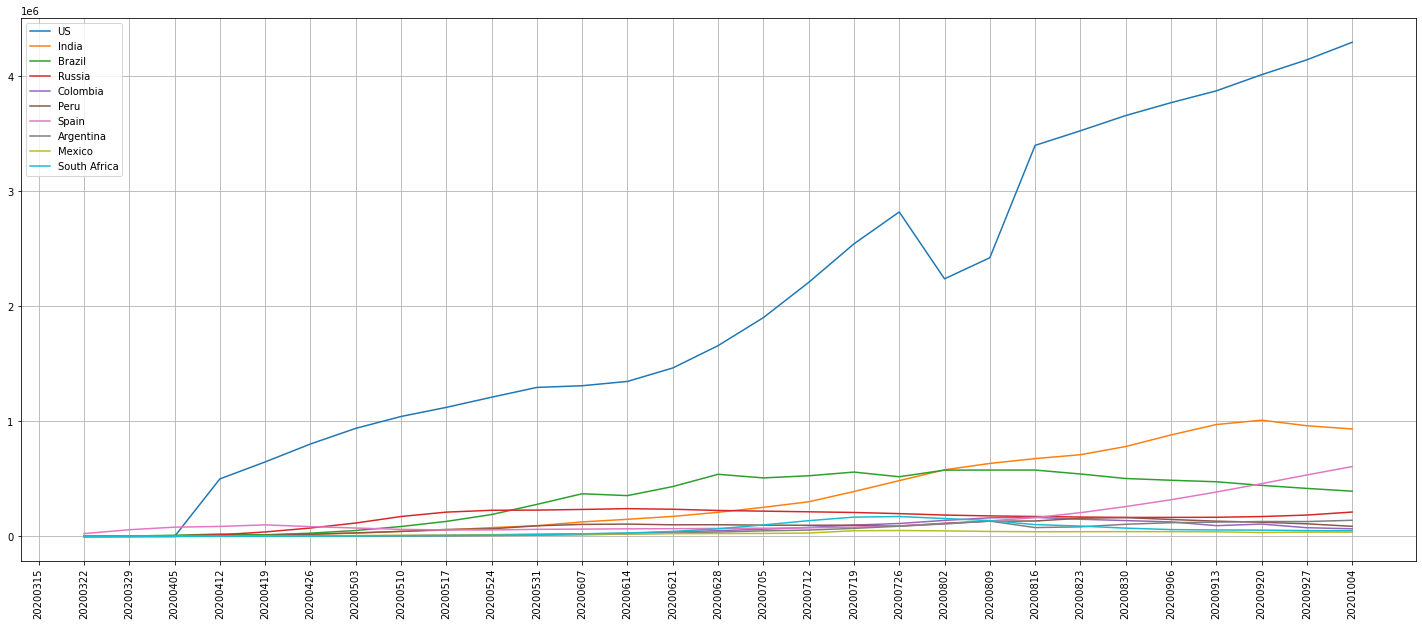

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

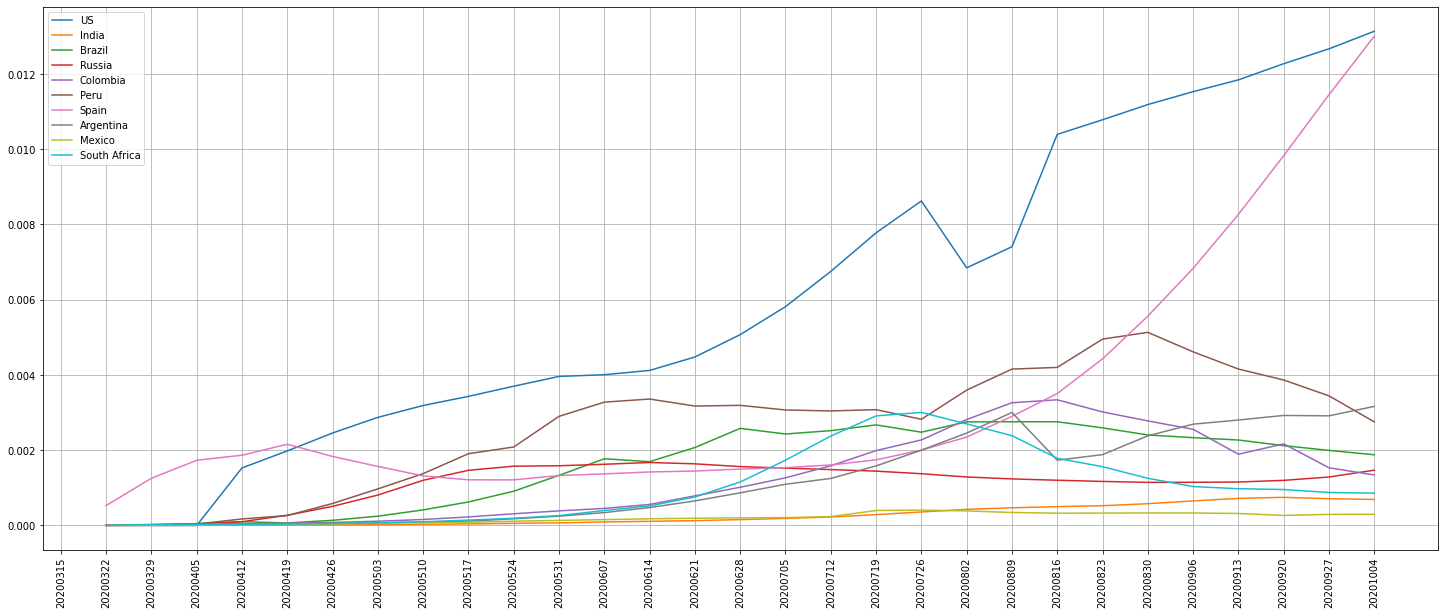

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

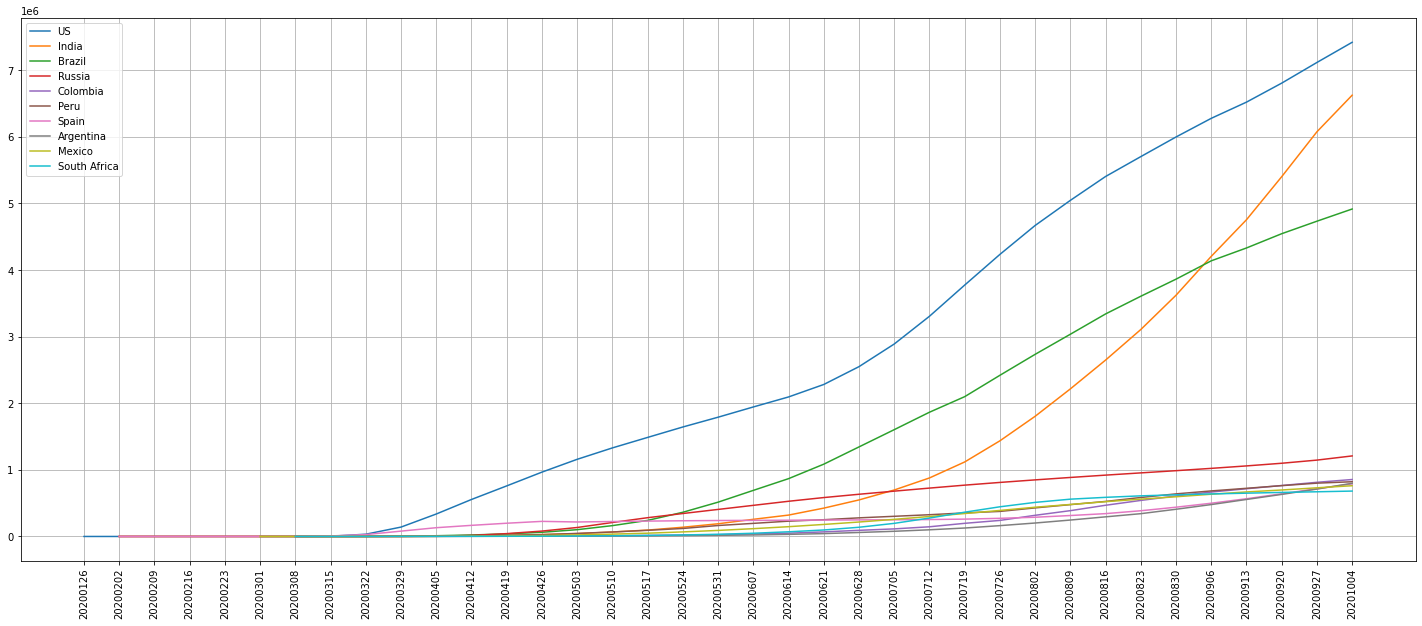

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

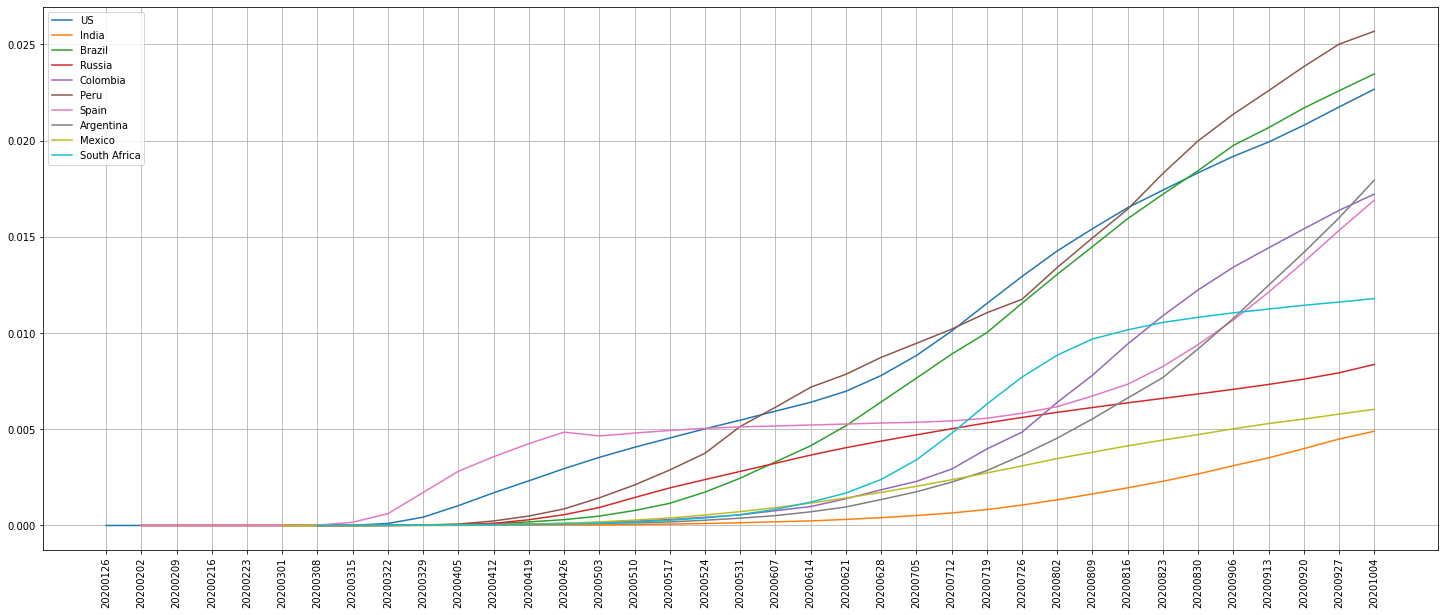

<IPython.core.display.Javascript object>

In [4]:
from google.colab import widgets
from matplotlib import pylab

graphs = list(sorted(set(Series['series_name'])))

tabbar = widgets.TabBar(graphs)

for g in graphs:
  with tabbar.output_to(g):
    pylab.figure(figsize=(25, 10))
    pylab.grid(True)
    for country in TopCountries['col0']:
      df = Series[(Series['country'] == country) & (Series['series_name'] == g)]
      pylab.plot(df['date'], df['value'], label=country)
    pylab.legend(loc='best')
    _ = pylab.xticks(rotation=90)



## Extracting potentially relevant indicators

In [5]:
%%logica CountryIndicators, CountryInfo

#######################################################################
# Assigning short names to required BigQuery public data tables.
WdiIndicators(..r) :-
  `bigquery-public-data.world_bank_wdi.indicators_data`(..r);

HealthIndicators(..r) :-
  `bigquery-public-data.world_bank_health_population.health_nutrition_population`(..r);

CovidData(..r) :- `bigquery-public-data.covid19_jhu_csse.summary`(..r);

##############################
# Collecting the data.

# Joining World Bank country indicator data.
@With(CountryIndicators);
CountryIndicators(
    country:,
    population:,
    gdp_per_capita:,
    overweight_fraction:,
    life_expectancy:) :-
  `bigquery-public-data.world_bank_global_population.population_by_country`(
      country: country_raw,
      year_2018: population
  ),
  WdiIndicators(year: 2018, value: gdp_per_capita, country_name: country_raw,
                indicator_code: "NY.GDP.PCAP.PP.CD"),
  HealthIndicators(year: 2016, value: overweight_fraction, country_name: country_raw,
                   indicator_code: "SH.STA.OWAD.ZS"),   
  HealthIndicators(year: 2016, value: life_expectancy, country_name: country_raw,
                   indicator_code: "SP.DYN.LE00.IN"),   
  # Map official country name to the name used in John Hopkins data.
  country == (
      if country_raw == "United States" then
        "US"
      else if country_raw == "Iran, Islamic Rep." then
        "Iran"
      else if country_raw == "Russian Federation" then
        "Russia"
      else
        country_raw
  );

# A function to retrieve World Bank indicators data for a country.
# Returns null if the data is not there. We use it to avoid countries
# disappearing from the final table if the name didn't match.
IndicatorsOf(country) = indicators :-
  indicators AnyValue= (r :- CountryIndicators(country:, ..r));

# Extracting total confirmed COVID cases and deaths from John Hopkins data. 
@OrderBy(CountryCases, "confirmed desc");
CountryCases(country: country_region,
             confirmed? += confirmed,
             deaths? += deaths) distinct :-
  CovidData(country_region:, confirmed:, deaths:, date:),
  date == DateAddDay(CurrentDate(), -4);

# Joinig all the data together.
CountryInfo(country:, 
            confirmed:,
            confirmed_per_capita: confirmed / indicators.population,
            deaths:,
            deaths_per_capita: deaths / indicators.population,
            deaths_per_confirmed: deaths / confirmed,
            ..indicators) :-
  indicators == IndicatorsOf(country),
  CountryCases(country:, confirmed:, deaths:),
  # Data for less than 1000 cases has especially high risk of being noisy.  
  confirmed > 1000; 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running CountryIndicators


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CountryIndicators_sql variable.
SELECT
  CASE WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "United States" THEN "US" WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "Iran, Islamic Rep." THEN "Iran" WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "Russian Federation" THEN "Russia" ELSE bigquerypublicdata_world_bank_global_population_population_by_country.country END AS country,
  bigquerypublicdata_world_bank_global_population_population_by_country.year_2018 AS population,
  bigquerypublicdata_world_bank_wdi_indicators_data.value AS gdp_per_capita,
  bigquerypublicdata_world_bank_health_population_health_nutrition_population.value AS overweight_fraction,
  t_1_bigquerypublicdata_world_bank_health_population_health_nutrition_population.value AS life_expectancy
FROM
  `bigquery-public-data.world_bank_global_population.population_by_country` AS 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CountryIndicators variable.


,country,population,gdp_per_capita,overweight_fraction,life_expectancy
0,Namibia,2448255,10166.337273,40.600000,62.625000
1,Panama,4176873,31781.844286,58.800000,77.964000
2,Estonia,1320884,36358.027763,55.800000,77.641463
3,Madagascar,26262368,1651.168811,23.900000,65.931000
4,Arab World,419790588,14972.430728,61.842887,71.436497
...,...,...,...,...,...
207,Bangladesh,161356039,4546.227418,1.000000,71.785000
208,El Salvador,6420744,8818.877207,59.900000,72.644000
209,Philippines,106651922,8717.047981,27.600000,70.802000
210,"Egypt, Arab Rep.",98423595,11634.546851,63.500000,71.482000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running CountryInfo


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CountryInfo_sql variable.
WITH t_0_CountryIndicators AS (SELECT
  CASE WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "United States" THEN "US" WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "Iran, Islamic Rep." THEN "Iran" WHEN bigquerypublicdata_world_bank_global_population_population_by_country.country = "Russian Federation" THEN "Russia" ELSE bigquerypublicdata_world_bank_global_population_population_by_country.country END AS country,
  bigquerypublicdata_world_bank_global_population_population_by_country.year_2018 AS population,
  bigquerypublicdata_world_bank_wdi_indicators_data.value AS gdp_per_capita,
  bigquerypublicdata_world_bank_health_population_health_nutrition_population.value AS overweight_fraction,
  t_2_bigquerypublicdata_world_bank_health_population_health_nutrition_population.value AS life_expectancy
FROM
  `bigquery-public-data.world_bank_global_population.p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CountryInfo variable.


,country,confirmed,confirmed_per_capita,deaths,deaths_per_capita,deaths_per_confirmed,population,gdp_per_capita,overweight_fraction,life_expectancy
0,US,7499341,0.022922,210886,0.000645,0.028121,327167434.0,62840.020239,67.9,78.539024
1,Chad,1238,0.000080,88,0.000006,0.071082,15477751.0,1613.514935,23.1,53.438000
2,Cuba,5883,NaN,123,NaN,0.020908,NaN,NaN,NaN,NaN
3,Iran,479825,NaN,27419,NaN,0.057144,NaN,NaN,NaN,NaN
4,Iraq,387121,0.010072,9531,0.000248,0.024620,38433600.0,10911.637908,64.6,70.122000
...,...,...,...,...,...,...,...,...,...,...
153,Congo (Brazzaville),5089,NaN,89,NaN,0.017489,NaN,NaN,NaN,NaN
154,Trinidad and Tobago,4846,0.003487,83,0.000060,0.017128,1389858.0,26892.868103,1.0,73.100000
155,United Arab Emirates,100794,0.010466,435,0.000045,0.004316,9630959.0,68548.514718,67.8,77.470000
156,Bosnia and Herzegovina,28710,0.008637,903,0.000272,0.031452,3323929.0,14932.373205,53.3,76.998000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

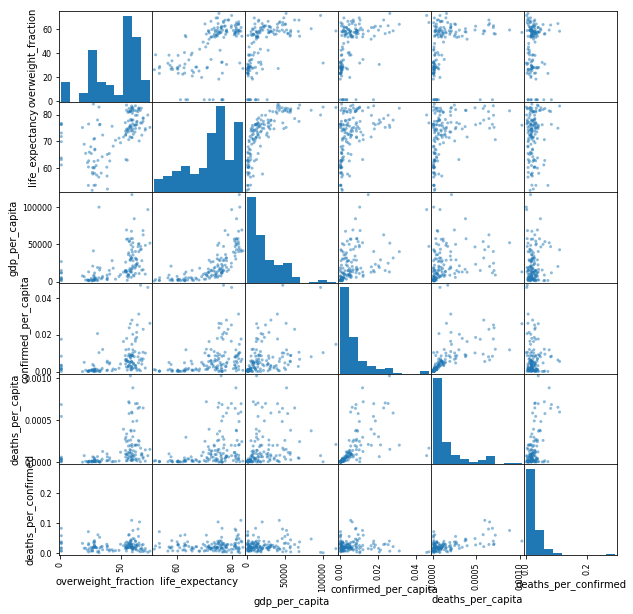

In [7]:
import pandas


_ = pandas.plotting.scatter_matrix(
    CountryInfo[['overweight_fraction', 'life_expectancy', 'gdp_per_capita',
                 'confirmed_per_capita', 'deaths_per_capita',
                 'deaths_per_confirmed']],
    figsize=(10, 10))